# Задача

Для решения была выбрана задача регрессии, а именно предсказания цены жилья в России в зависимости от его параметров.

### Разведочный анализ

Данные в виду .csv таблицы можно скачать [здесь](https://www.kaggle.com/datasets/mrdaniilak/russia-real-estate-2021)

Описание датасета:
* **date** - дата публикации объявления о продаже жилья
* **price** - цена на жилье в рублях
* **level** - этаж на котором расположено жилье
* **levels** - количество этажей в здании
* **rooms** - количество жилых комнат в помещении (если -1, то жилье это студия)
* **area** - площадь жилья
* **kitchen_area** - площадь кухни (если -100, то неизвестно)
* **id_region** - регион России в котором расположено жилье
* **geo_lat** и **geo_lon** - координаты жилья на всемирной карте
* **building_type** - тип жилья, может принимать набор значений:
    1. 0, 1 - неизвестный тип
    2. 2 - панельный дом
    3. 3 - монолитный дом
    4. 4 - кирпичный дом
    5. 5 - блочный дом
    6. 6 - деревянный дом

Необходимо решить задачу регрессии и научится предсказывать целевой признак **price**.

Подключим библиотеки

In [1]:
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# устанавливаем точность чисел с плавающей точкой
%precision %.4f

import warnings
warnings.filterwarnings("ignore")

Считаем данные

In [2]:
russian_housing_df = pd.read_csv('../data/task4/russian_housing/input_data.csv',
                                 sep=';',
                                 usecols=["date", "price", "geo_lat", "geo_lon", "level", "levels", "rooms", "area", "kitchen_area", "id_region", "building_type"],
                                 nrows=100000
)

In [3]:
russian_housing_df.head()

,date,price,level,levels,rooms,area,kitchen_area,geo_lat,geo_lon,building_type,id_region
0,2021-01-01,2451300,15,31,1,30.3,0.0,56.780112,60.699355,0,66
1,2021-01-01,1450000,5,5,1,33.0,6.0,44.608154,40.138381,0,1
2,2021-01-01,10700000,4,13,3,85.0,12.0,55.540060,37.725112,3,50
3,2021-01-01,3100000,3,5,3,82.0,9.0,44.608154,40.138381,0,1
4,2021-01-01,2500000,2,3,1,30.0,9.0,44.738685,37.713668,3,23


Можно проверить, что в данных нет пропущенным значений

In [4]:
russian_housing_df.isnull().sum()

date             0
price            0
level            0
levels           0
rooms            0
area             0
kitchen_area     0
geo_lat          0
geo_lon          0
building_type    0
id_region        0
dtype: int64

### Анализ признаков

##### Признак id_region

В первую очередь хочется обратить внимание на признак **id_region**. Здравый смысл подсказывает, что регион, в котором расположено жилье, должен существенно влиять на стоимость этого жилья.

<Axes: xlabel='id_region', ylabel='price'>

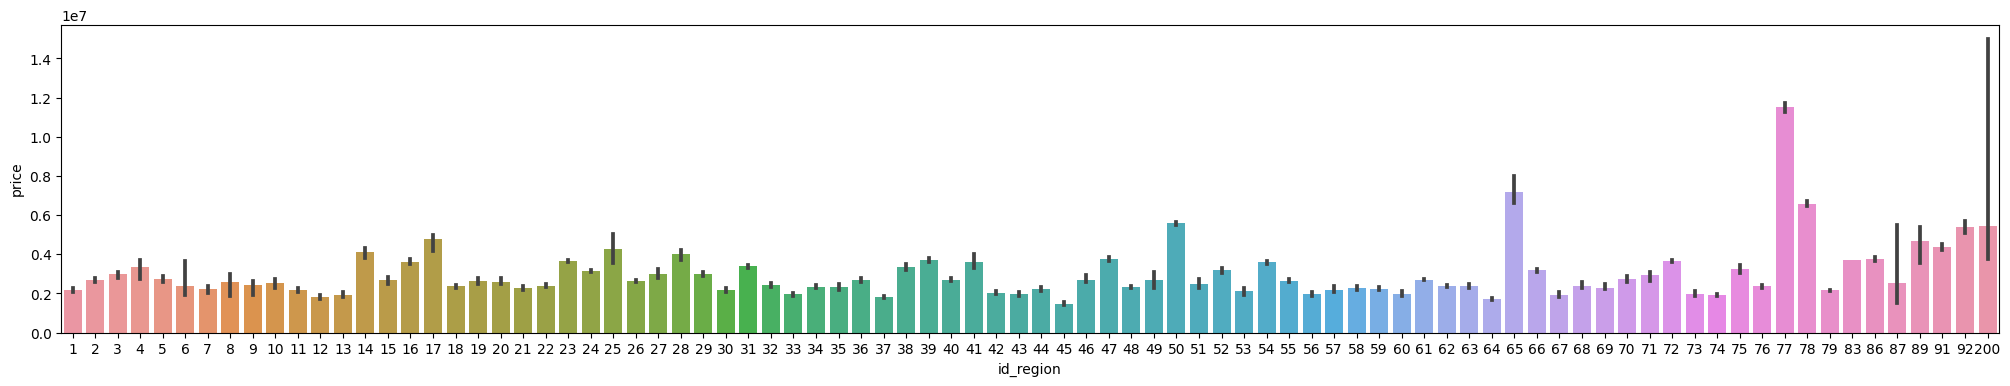

In [5]:
plt.figure(figsize=(25,4))
sns.barplot(x='id_region', y='price', data=russian_housing_df, log=False, estimator="median")

Невооруженным взглядом видно, что средняя стоимость жилья в некоторых регионах, таких как Москва (77 на графике) существенно выше, чем в других. Вероятно данный признак очень существенен при оценке жилья. Тем не менее, признак содержит очень много различных значений, и кажется его лучше упростить. Разобьем жилье по стоимости на 3 категории **region_category**: 0 - самые дешевые регионы, 1 - средние по цене регионы (будем считать такими регионы со средней ценой от 5 до 10 миллионов рублей), 2 - самые дорогие регионы.

In [6]:
russian_housing_df['region_category'] = 0  # заполняем сначала значения нового признака нулями
for i in range(92):
    id_region = i + 1
    m = russian_housing_df.loc[russian_housing_df["id_region"] == id_region, "price"].mean()
    if 10_000_000 > m > 5_000_000:
        russian_housing_df.loc[russian_housing_df["id_region"] == id_region, "region_category"] = 1
    elif m >= 10_000_000:
        russian_housing_df.loc[russian_housing_df["id_region"] == id_region, "region_category"] = 2

In [7]:
russian_housing_df.head()

,date,price,level,levels,rooms,area,kitchen_area,geo_lat,geo_lon,building_type,id_region,region_category
0,2021-01-01,2451300,15,31,1,30.3,0.0,56.780112,60.699355,0,66,0
1,2021-01-01,1450000,5,5,1,33.0,6.0,44.608154,40.138381,0,1,0
2,2021-01-01,10700000,4,13,3,85.0,12.0,55.540060,37.725112,3,50,1
3,2021-01-01,3100000,3,5,3,82.0,9.0,44.608154,40.138381,0,1,0
4,2021-01-01,2500000,2,3,1,30.0,9.0,44.738685,37.713668,3,23,1


In [8]:
russian_housing_df.drop(["id_region"], axis=1, inplace=True)

##### Признаки level и levels

Также важным признаком при оценке жилья кажется этаж, на котором жилье находится.

<Axes: xlabel='level', ylabel='price'>

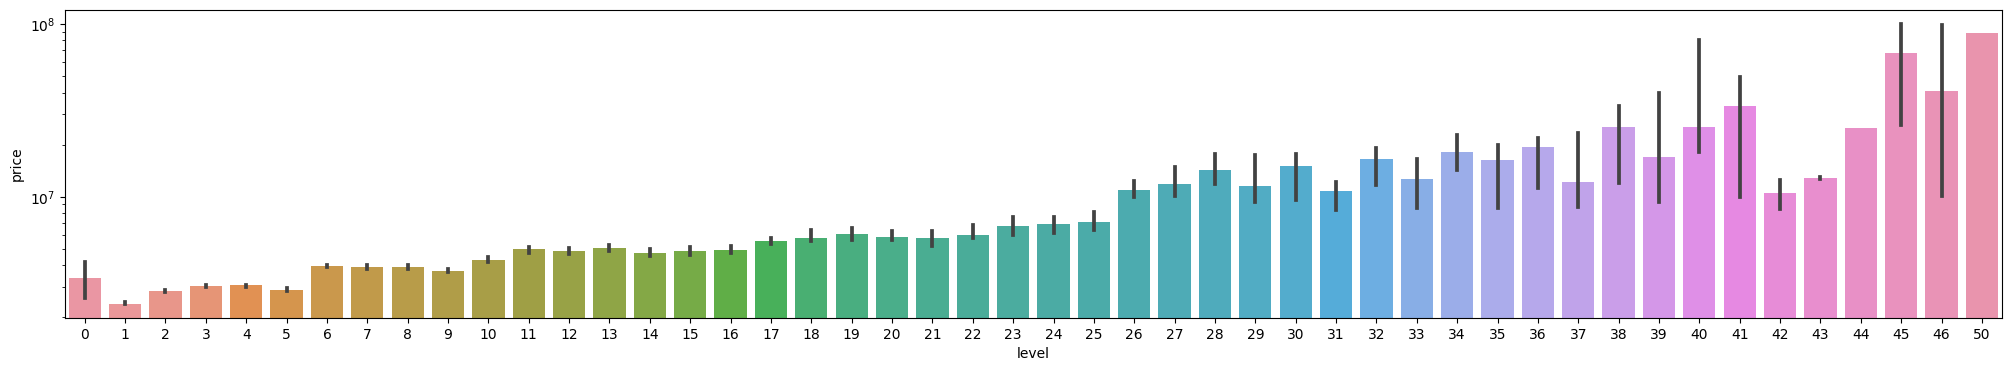

In [9]:
plt.figure(figsize=(25,4))
sns.barplot(x='level', y='price', data=russian_housing_df, log=True, estimator="median")

На графике можно заметить непонятный 0 этаж, вероятно это какие то подвальные помещения, частные дома или невалидные данные. Как бы то ни было, на графике не сложно заметить такую тенденцию, что стоимость жилья на более низких этажах существенно меньше стоимости на более высоких. Это может быть связано как с тем, что более высотные дома являются более новыми и стоимость жилья в них выше впринципе, так и с тем, что проживания на более низких этажах влечет за собой неудобства.

Посмотрим на зависимость цены жилья от этажности дома.

<Axes: xlabel='levels', ylabel='price'>

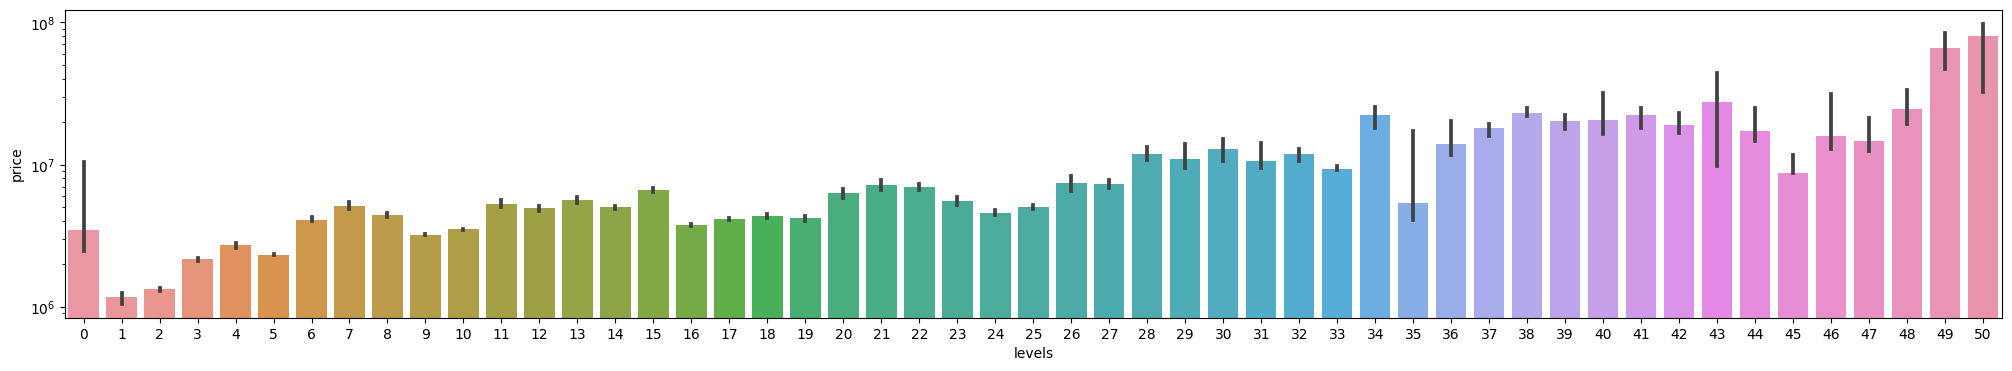

In [10]:
plt.figure(figsize=(25,4))
sns.barplot(x='levels', y='price', data=russian_housing_df, log=True, estimator="median")

Кажется, что тенденция такая же как и у предыдущего графика - чем выше этаж, тым выше цена жилья. Так как зависимость цены от высоты дома очень похожа на зависимость цены от этажа, на котором располагается квартира, кажется разумным избавится от признака **levels** и оставить только признак **level**, тем более что они имеют очень высокую корреляцию.

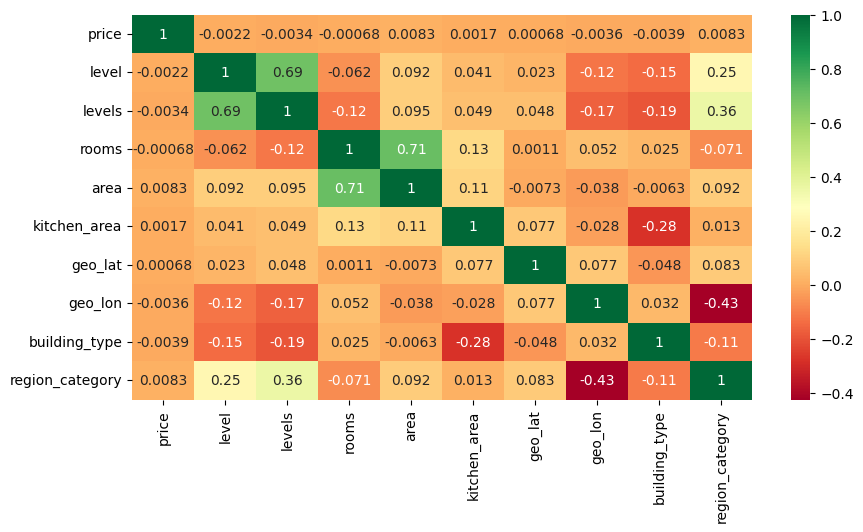

In [11]:
sns.heatmap(russian_housing_df.corr(), annot=True, cmap='RdYlGn')
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.show()

Исключим признак levels из датафрейма.

In [12]:
russian_housing_df.drop(["levels"], axis=1, inplace=True)

In [13]:
russian_housing_df.head()

,date,price,level,rooms,area,kitchen_area,geo_lat,geo_lon,building_type,region_category
0,2021-01-01,2451300,15,1,30.3,0.0,56.780112,60.699355,0,0
1,2021-01-01,1450000,5,1,33.0,6.0,44.608154,40.138381,0,0
2,2021-01-01,10700000,4,3,85.0,12.0,55.540060,37.725112,3,1
3,2021-01-01,3100000,3,3,82.0,9.0,44.608154,40.138381,0,0
4,2021-01-01,2500000,2,1,30.0,9.0,44.738685,37.713668,3,1


##### Признаки rooms, area и kitchen_area

Посмотрим, как цена зависит от площади кухни, общей площади и количества комнат

<Axes: xlabel='kitchen_area', ylabel='price'>

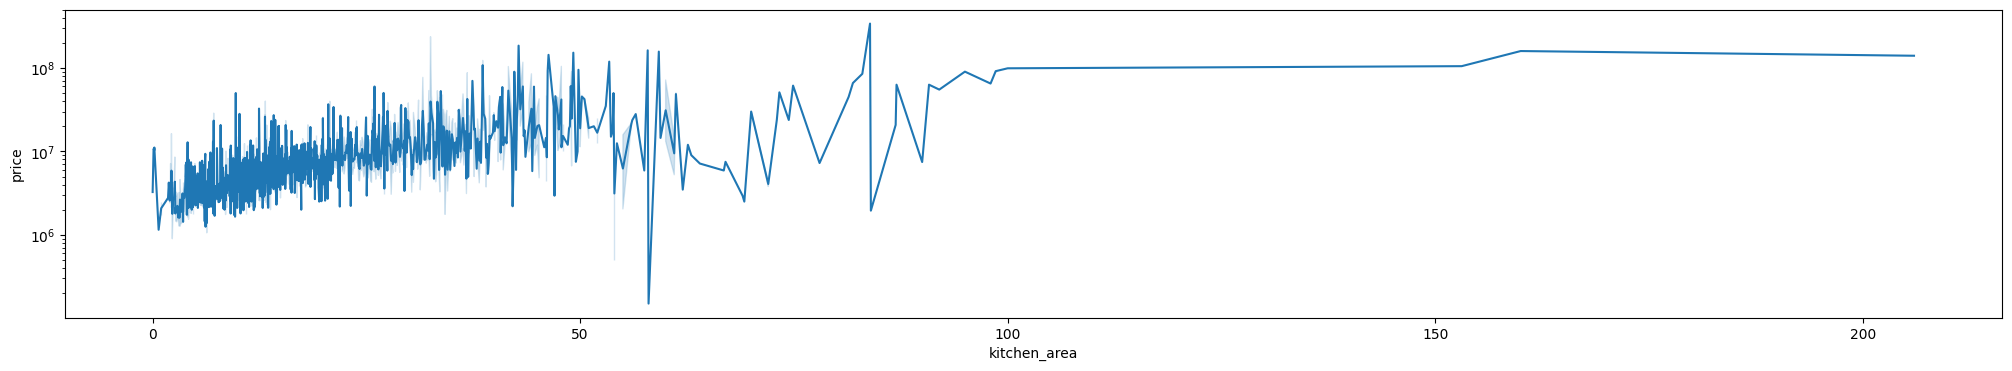

In [14]:
plt.figure(figsize=(25,4))
plt.yscale('log')
sns.lineplot(x='kitchen_area', y='price', data=russian_housing_df[russian_housing_df["kitchen_area"] != -100])

<Axes: xlabel='area', ylabel='price'>

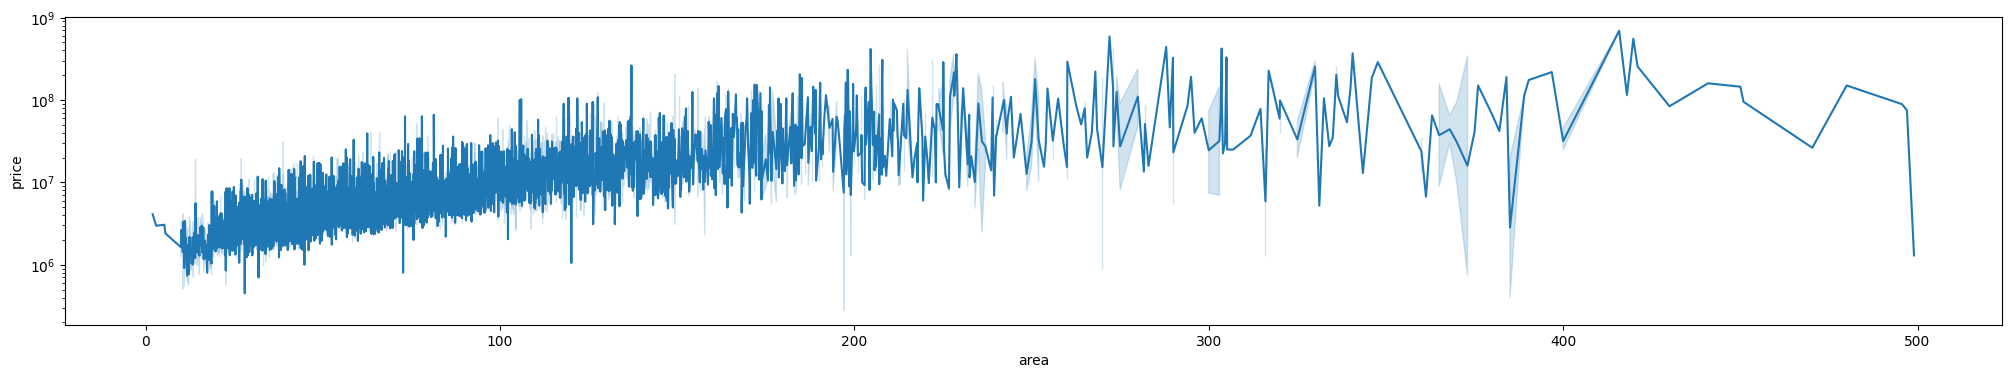

In [15]:
plt.figure(figsize=(25,4))
plt.yscale('log')
sns.lineplot(x='area', y='price', data=russian_housing_df)

<Axes: xlabel='rooms', ylabel='price'>

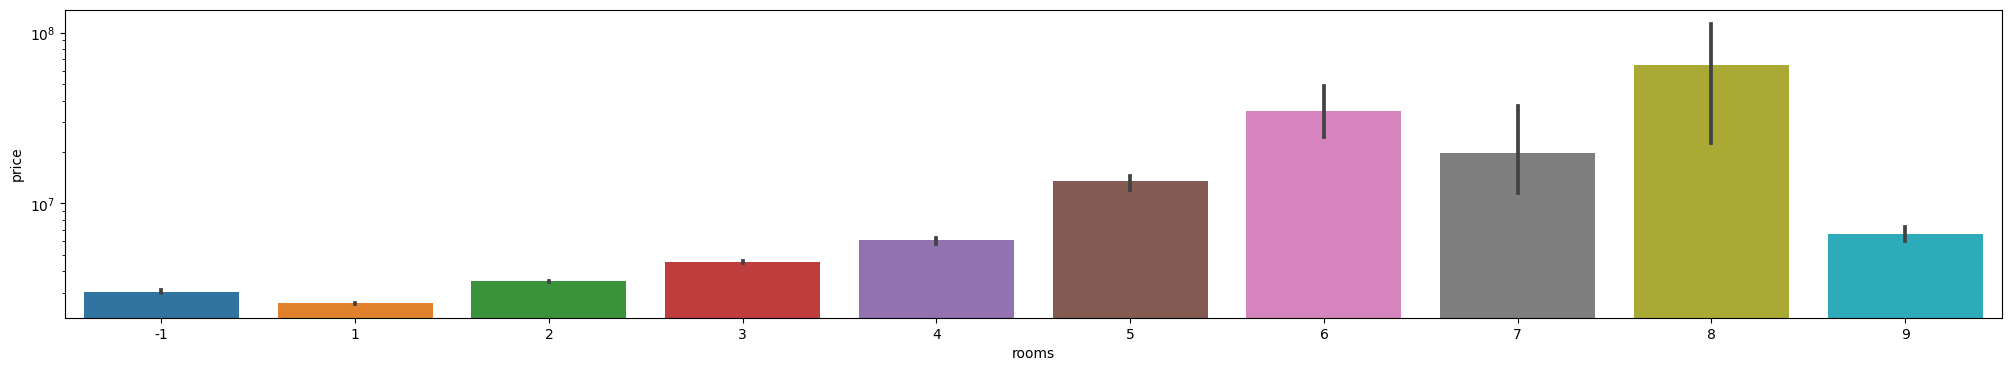

In [16]:
plt.figure(figsize=(25,4))
sns.barplot(x='rooms', y='price', data=russian_housing_df, log=True, estimator="median")

Не трудно заметить, что для всех трех параметров наблюдается одинаковая тенденция - цена растет от увеличения площади. Также бытовая логика подсказывает, что все три параметра сильно связаны между собой (кроме того общая площадь и количество комнат сильно коррелируют между собой), и наиболее важный из этих параметров это общая площадь. Ее и оставим.

In [17]:
russian_housing_df.drop(["kitchen_area"], axis=1, inplace=True)
russian_housing_df.drop(["rooms"], axis=1, inplace=True)

In [18]:
russian_housing_df.head()

,date,price,level,area,geo_lat,geo_lon,building_type,region_category
0,2021-01-01,2451300,15,30.3,56.780112,60.699355,0,0
1,2021-01-01,1450000,5,33.0,44.608154,40.138381,0,0
2,2021-01-01,10700000,4,85.0,55.540060,37.725112,3,1
3,2021-01-01,3100000,3,82.0,44.608154,40.138381,0,0
4,2021-01-01,2500000,2,30.0,44.738685,37.713668,3,1


##### Признак date

Так как мы хотим оценивать стоимость жилья относительно параметров самого жилья, параметр date кажется излишним, просто удалим его

In [19]:
russian_housing_df.drop(["date"], axis=1, inplace=True)

In [20]:
russian_housing_df.head()

,price,level,area,geo_lat,geo_lon,building_type,region_category
0,2451300,15,30.3,56.780112,60.699355,0,0
1,1450000,5,33.0,44.608154,40.138381,0,0
2,10700000,4,85.0,55.540060,37.725112,3,1
3,3100000,3,82.0,44.608154,40.138381,0,0
4,2500000,2,30.0,44.738685,37.713668,3,1


##### Признак building_type

Последний неисследованный признак это building_type, посмотрим как он влияет на цену жилья.

<Axes: xlabel='building_type', ylabel='price'>

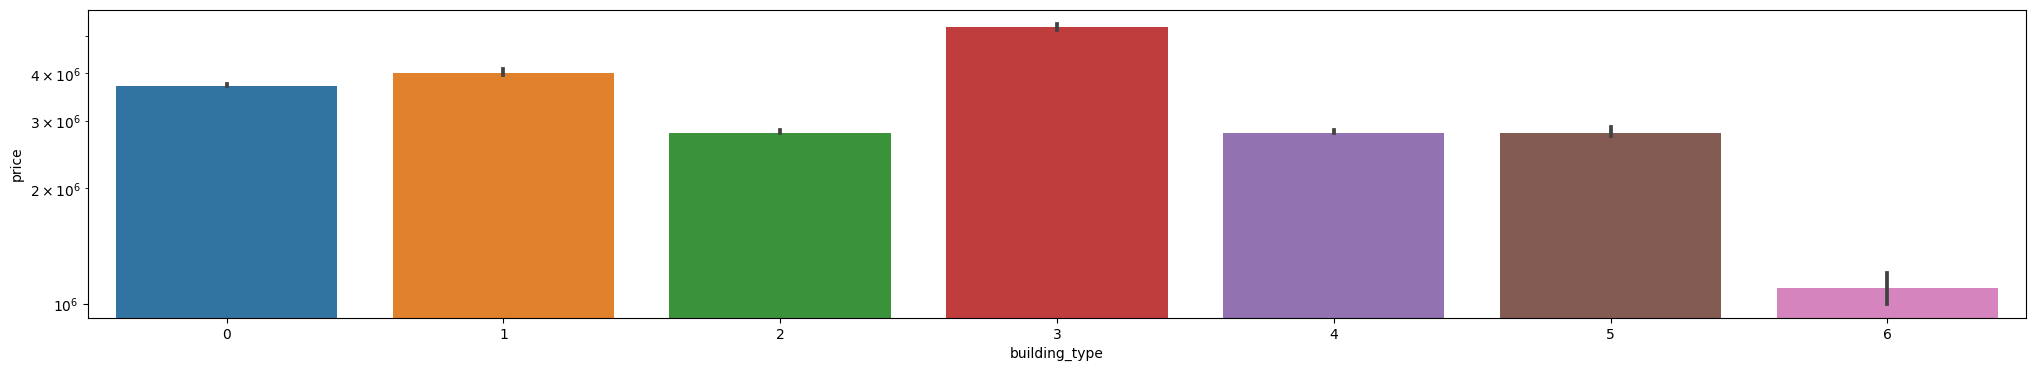

In [21]:
plt.figure(figsize=(25,4))
sns.barplot(x='building_type', y='price', data=russian_housing_df, log=True, estimator="median")

Невооруженным взглядом можно заметить одну тенденцию - деревянные дома существенно дешевле, чем остальные. Упростим признак до того, является ли конкретный дом деревянным или нет

In [22]:
russian_housing_df['is_wood_house'] = 0
russian_housing_df.loc[(russian_housing_df['building_type'] == 6), 'is_wood_house'] = 1
russian_housing_df.drop(["building_type"], axis=1, inplace=True)

In [23]:
russian_housing_df.head()

,price,level,area,geo_lat,geo_lon,region_category,is_wood_house
0,2451300,15,30.3,56.780112,60.699355,0,0
1,1450000,5,33.0,44.608154,40.138381,0,0
2,10700000,4,85.0,55.540060,37.725112,1,0
3,3100000,3,82.0,44.608154,40.138381,0,0
4,2500000,2,30.0,44.738685,37.713668,1,0


##### Признаки geo_lat и geo_lon

Здравый смысл подсказывает, что геопозиция жилья должна очень сильно влиять на цену, даже в рамках одного региона. Посмотрим распределение цен на дома в зависимости от координат

<Axes: xlabel='geo_lon', ylabel='geo_lat'>

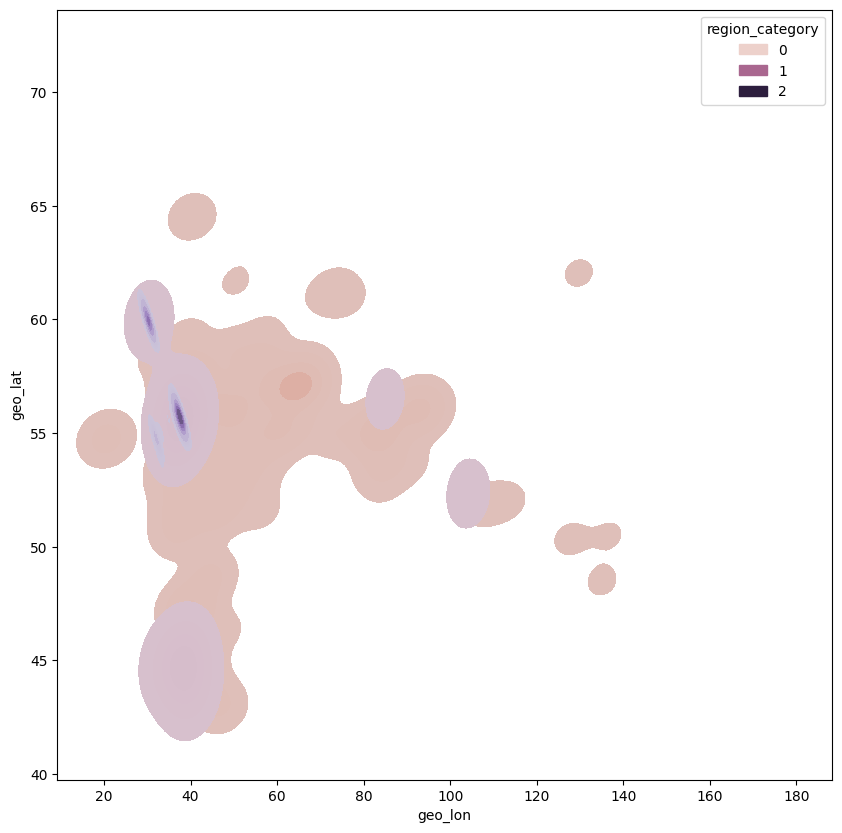

In [24]:
plt.figure(figsize=(10,10))
sns.kdeplot(x='geo_lon', y='geo_lat', data=russian_housing_df, fill=True, hue="region_category")

Очень хорошо видно, что ближе к административным центрам цены на жилье сильно выше. Особенно выделяется Москва, занимающая самое светлое место на данном графике (с самым дорогим жильем). Таким образом, географические координаты важный параметр и могут сильно повлиять на итоговое предсказание.

### Обучение моделей

Перед тем, как обучать какие-либо модели, реализуем алгоритмы AdaBoost и Bagging для деревьев принятых решений.

In [25]:
from sklearn.utils.validation import _num_samples, check_is_fitted
from sklearn.utils import check_X_y
from sklearn.utils.estimator_checks import check_estimator
from sklearn.base import RegressorMixin, BaseEstimator
from sklearn.utils.extmath import stable_cumsum
from sklearn.metrics import mean_absolute_error
from sklearn import clone
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils import check_random_state


class Task4AdaBoostRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, n_regressors = 5, random_state=None):
        self.n_regressors = n_regressors
        self.random_state = random_state

    def _set_random_states(self, new_regressor):
        random_states = {}
        for param_name in new_regressor.get_params(deep=True):
            if param_name == "random_state" or param_name.endswith("__random_state"):
                random_states[param_name] = self.random_state_.tomaxint() % 4294967295 # got very big numbers in tests and made fix to limit integer random value
        new_regressor.set_params(**random_states)

    def fit(self, X, y):
        self.random_state_ = check_random_state(self.random_state)
        self.regressors_ = []
        self.regressor_weights_ = []

        X, y = check_X_y(X, y, y_numeric=True)

        weights = np.full(len(y), fill_value=(1 / len(y)))
        for _ in range(self.n_regressors):
            new_regressor = DecisionTreeRegressor()
            self._set_random_states(new_regressor)
            predict_result = new_regressor.fit(X, y, sample_weight=weights).predict(X)

            errors = np.abs(predict_result - y)
            max_error = errors.max()
            if max_error > 0:
                errors /= max_error
            abs_error = np.sum(errors * weights)

            if abs_error == 0:
                self.regressors_.append(new_regressor)
                self.regressor_weights_.append(1)
                break

            beta = abs_error / (1.0 - abs_error)
            weights *= np.power(beta, (1.0 - errors))

            weights /= np.sum(weights)
            self.regressors_.append(new_regressor)
            self.regressor_weights_.append(np.log(1 / beta))

        self._regressor_weights = np.array(self.regressor_weights_)
        self.n_features_in_ = X.shape[1]

        return self

    def predict(self, X):
        check_is_fitted(self)
        predictions = np.array([regressor.predict(X) for regressor in self.regressors_]).T

        sorted_idx = np.argsort(predictions, axis=1)

        sorted_weights_cumsum = stable_cumsum(self._regressor_weights[sorted_idx], axis=1)
        is_median_or_above = sorted_weights_cumsum >= 0.5 * sorted_weights_cumsum[:, -1][:, np.newaxis]
        median_ids = np.argmax(is_median_or_above, axis=1)
        median_ids = sorted_idx[np.arange(_num_samples(X)), median_ids]

        aggregated = predictions[np.arange(_num_samples(X)), median_ids]
        return aggregated

check_estimator(Task4AdaBoostRegressor())

In [26]:
class Task4BaggingRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, n_regressors = 5, random_state = None):
        self.n_regressors = n_regressors
        self.random_state = random_state

    def _set_random_states(self, new_regressor):
        random_states = {}
        for param_name in new_regressor.get_params(deep=True):
            if param_name == "random_state" or param_name.endswith("__random_state"):
                random_states[param_name] = self.random_state_.tomaxint() % 4294967295 # got very big numbers in tests and made fix to limit integer random value
        new_regressor.set_params(**random_states)

    def fit(self, X, y):
        self.regressors_ = []
        self.random_state_ = check_random_state(self.random_state)

        X, y = check_X_y(X, y, y_numeric=True)

        for _ in range(self.n_regressors):
            new_regressor = DecisionTreeRegressor()
            self._set_random_states(new_regressor)
            random_indices = self.random_state_.choice(len(y), len(y))
            X_sample, y_sample = X[random_indices], y[random_indices]
            new_regressor.fit(X_sample, y_sample)
            self.regressors_.append(new_regressor)

        self.n_features_in_ = X.shape[1]
        return self

    def predict(self, X):
        check_is_fitted(self)
        predictions = [regressor.predict(X) for regressor in self.regressors_]

        aggregated = np.mean(predictions, axis=0)
        return aggregated

check_estimator(Task4BaggingRegressor())

Теперь сравним модели:

In [27]:
X = russian_housing_df.drop(["price"], axis=1)
y = russian_housing_df["price"] // 1000 # переведем цену в сотни тысяч

print("X")
print(X.head())
print()
print("y")
print(y.head())

X
   level  area    geo_lat    geo_lon  region_category  is_wood_house
0     15  30.3  56.780112  60.699355                0              0
1      5  33.0  44.608154  40.138381                0              0
2      4  85.0  55.540060  37.725112                1              0
3      3  82.0  44.608154  40.138381                0              0
4      2  30.0  44.738685  37.713668                1              0

y
0     2451
1     1450
2    10700
3     3100
4     2500
Name: price, dtype: int64


In [28]:
from sklearn.model_selection import KFold
from optuna.integration import OptunaSearchCV
import sklearn.model_selection as sk

def cross_validate(regressor, param_grid):
    model = OptunaSearchCV(
        regressor,
        param_grid,
        scoring="neg_mean_absolute_error"
    )

    cv_results = sk.cross_validate(
        model,
        X.values,
        y.values,
        scoring=["r2", "neg_mean_absolute_error"],
        cv=KFold(shuffle=True, n_splits=7),
        return_estimator=True,
        return_train_score=True,
        n_jobs=3
    )

    for fold_i, estimator_in_fold in enumerate(cv_results["estimator"], start=1):
        print(f"Лучшие параметры #{fold_i}:", estimator_in_fold.best_params_)

    cv_results = pd.DataFrame(cv_results).rename(
        columns={"estimator": "regressor"}
    )
    cv_results["regressor"] = regressor.__class__.__name__.removesuffix("Regressor")
    return cv_results

# Замеры

In [29]:
%%time
from optuna.distributions import CategoricalDistribution

task_4_bagging_regressor = cross_validate(
    Task4BaggingRegressor(),
    param_grid={
        "n_regressors": CategoricalDistribution([40, 60, 80])
    }
)

Лучшие параметры #1: {'n_regressors': 60}
Лучшие параметры #2: {'n_regressors': 40}
Лучшие параметры #3: {'n_regressors': 40}
Лучшие параметры #4: {'n_regressors': 80}
Лучшие параметры #5: {'n_regressors': 80}
Лучшие параметры #6: {'n_regressors': 60}
Лучшие параметры #7: {'n_regressors': 80}
CPU times: user 2.76 s, sys: 6.01 s, total: 8.77 s
Wall time: 1h 9min 3s


In [30]:
o%%time
from sklearn.ensemble import BaggingRegressor

sklearn_bagging_regressor = cross_validate(
    BaggingRegressor(),
    param_grid={
        "n_estimators": CategoricalDistribution([40, 60, 80])
    }
)

Лучшие параметры #1: {'n_estimators': 40}
Лучшие параметры #2: {'n_estimators': 40}
Лучшие параметры #3: {'n_estimators': 40}
Лучшие параметры #4: {'n_estimators': 80}
Лучшие параметры #5: {'n_estimators': 60}
Лучшие параметры #6: {'n_estimators': 40}
Лучшие параметры #7: {'n_estimators': 40}
CPU times: user 2.16 s, sys: 3.45 s, total: 5.61 s
Wall time: 54min 32s


In [31]:
%%time
from sklearn.ensemble import AdaBoostRegressor

ada_boost_regressor = cross_validate(
    AdaBoostRegressor(),
    param_grid={
        "n_estimators": CategoricalDistribution([40, 60, 80])
    }
)

Лучшие параметры #1: {'n_estimators': 40}
Лучшие параметры #2: {'n_estimators': 40}
Лучшие параметры #3: {'n_estimators': 60}
Лучшие параметры #4: {'n_estimators': 40}
Лучшие параметры #5: {'n_estimators': 80}
Лучшие параметры #6: {'n_estimators': 40}
Лучшие параметры #7: {'n_estimators': 40}
CPU times: user 109 ms, sys: 161 ms, total: 270 ms
Wall time: 4min 37s


In [32]:
%%time

task_4_ada_boost_regressor = cross_validate(
    Task4AdaBoostRegressor(),
    param_grid={
        "n_regressors": CategoricalDistribution([40, 60, 80])
    }
)

Лучшие параметры #1: {'n_regressors': 40}
Лучшие параметры #2: {'n_regressors': 40}
Лучшие параметры #3: {'n_regressors': 60}
Лучшие параметры #4: {'n_regressors': 80}
Лучшие параметры #5: {'n_regressors': 60}
Лучшие параметры #6: {'n_regressors': 40}
Лучшие параметры #7: {'n_regressors': 80}
CPU times: user 4.05 s, sys: 7.45 s, total: 11.5 s
Wall time: 1h 30min 10s


In [33]:
%%time
from sklearn.ensemble import RandomForestRegressor

random_forest_regressor = cross_validate(
    RandomForestRegressor(),
    param_grid={
        "n_estimators": CategoricalDistribution([100, 150, 200]),
        "max_leaf_nodes": CategoricalDistribution([10, 100])
    }
)

Лучшие параметры #1: {'n_estimators': 150, 'max_leaf_nodes': 100}
Лучшие параметры #2: {'n_estimators': 100, 'max_leaf_nodes': 100}
Лучшие параметры #3: {'n_estimators': 200, 'max_leaf_nodes': 100}
Лучшие параметры #4: {'n_estimators': 100, 'max_leaf_nodes': 100}
Лучшие параметры #5: {'n_estimators': 100, 'max_leaf_nodes': 100}
Лучшие параметры #6: {'n_estimators': 150, 'max_leaf_nodes': 100}
Лучшие параметры #7: {'n_estimators': 150, 'max_leaf_nodes': 100}
CPU times: user 292 ms, sys: 262 ms, total: 554 ms
Wall time: 40min 39s


In [34]:
%%time
from sklearn.ensemble import GradientBoostingRegressor

gradient_tree_boosting_regressor = cross_validate(
    GradientBoostingRegressor(),
    param_grid={
        "n_estimators": CategoricalDistribution([100, 150, 200]),
        "max_leaf_nodes": CategoricalDistribution([10, 100])
    }
)

Лучшие параметры #1: {'n_estimators': 200, 'max_leaf_nodes': 10}
Лучшие параметры #2: {'n_estimators': 150, 'max_leaf_nodes': 10}
Лучшие параметры #3: {'n_estimators': 200, 'max_leaf_nodes': 10}
Лучшие параметры #4: {'n_estimators': 150, 'max_leaf_nodes': 100}
Лучшие параметры #5: {'n_estimators': 200, 'max_leaf_nodes': 10}
Лучшие параметры #6: {'n_estimators': 200, 'max_leaf_nodes': 100}
Лучшие параметры #7: {'n_estimators': 200, 'max_leaf_nodes': 10}
CPU times: user 246 ms, sys: 220 ms, total: 466 ms
Wall time: 41min 47s


In [35]:
%%time
from sklearn.ensemble import HistGradientBoostingRegressor

hist_gradient_tree_boosting_regressor = cross_validate(
    HistGradientBoostingRegressor(),
    param_grid={
        "max_iter": CategoricalDistribution([100, 200, 300]),
        "max_leaf_nodes": CategoricalDistribution([10, 15, 20])
    }
)

Лучшие параметры #1: {'max_iter': 300, 'max_leaf_nodes': 20}
Лучшие параметры #2: {'max_iter': 300, 'max_leaf_nodes': 15}
Лучшие параметры #3: {'max_iter': 300, 'max_leaf_nodes': 20}
Лучшие параметры #4: {'max_iter': 100, 'max_leaf_nodes': 15}
Лучшие параметры #5: {'max_iter': 300, 'max_leaf_nodes': 20}
Лучшие параметры #6: {'max_iter': 100, 'max_leaf_nodes': 15}
Лучшие параметры #7: {'max_iter': 200, 'max_leaf_nodes': 15}
CPU times: user 95.2 ms, sys: 198 ms, total: 293 ms
Wall time: 35.6 s


In [36]:
%%time
from xgboost import XGBRegressor

xgb_regressor = cross_validate(
    XGBRegressor(),
    param_grid={
        "n_estimators": CategoricalDistribution([100, 150, 200]),
        "max_leaves": CategoricalDistribution([10, 15, 20])
    }
)

Лучшие параметры #1: {'n_estimators': 200, 'max_leaves': 20}
Лучшие параметры #2: {'n_estimators': 200, 'max_leaves': 10}
Лучшие параметры #3: {'n_estimators': 200, 'max_leaves': 20}
Лучшие параметры #4: {'n_estimators': 200, 'max_leaves': 20}
Лучшие параметры #5: {'n_estimators': 200, 'max_leaves': 15}
Лучшие параметры #6: {'n_estimators': 200, 'max_leaves': 10}
Лучшие параметры #7: {'n_estimators': 200, 'max_leaves': 10}
CPU times: user 443 ms, sys: 196 ms, total: 639 ms
Wall time: 27min 12s


In [37]:
%%time
from lightgbm import LGBMRegressor

light_bgm_regressor = cross_validate(
    LGBMRegressor(),
    param_grid={
        "n_estimators": CategoricalDistribution([100, 150, 200]),
        "num_leaves": CategoricalDistribution([10, 20, 30])
    }
)

Лучшие параметры #1: {'n_estimators': 100, 'num_leaves': 20}
Лучшие параметры #2: {'n_estimators': 200, 'num_leaves': 20}
Лучшие параметры #3: {'n_estimators': 150, 'num_leaves': 20}
Лучшие параметры #4: {'n_estimators': 100, 'num_leaves': 20}
Лучшие параметры #5: {'n_estimators': 100, 'num_leaves': 20}
Лучшие параметры #6: {'n_estimators': 100, 'num_leaves': 30}
Лучшие параметры #7: {'n_estimators': 100, 'num_leaves': 20}
CPU times: user 303 ms, sys: 91 ms, total: 394 ms
Wall time: 1min 50s


In [38]:
%%time
from catboost import CatBoostRegressor

cat_boost_regressor = cross_validate(
    CatBoostRegressor(silent=True),
    param_grid={
        "n_estimators": CategoricalDistribution([300, 400, 600]),
    }
)

Лучшие параметры #1: {'n_estimators': 600}
Лучшие параметры #2: {'n_estimators': 600}
Лучшие параметры #3: {'n_estimators': 300}
Лучшие параметры #4: {'n_estimators': 600}
Лучшие параметры #5: {'n_estimators': 600}
Лучшие параметры #6: {'n_estimators': 600}
Лучшие параметры #7: {'n_estimators': 600}
CPU times: user 131 ms, sys: 37.5 ms, total: 169 ms
Wall time: 20min


In [39]:
results = pd.concat([task_4_bagging_regressor, sklearn_bagging_regressor, ada_boost_regressor, task_4_ada_boost_regressor, random_forest_regressor,
                     gradient_tree_boosting_regressor, hist_gradient_tree_boosting_regressor, xgb_regressor, light_bgm_regressor, cat_boost_regressor])
results.loc[results["test_neg_mean_absolute_error"] < 0, "test_neg_mean_absolute_error"] *= -1
results.loc[results["train_neg_mean_absolute_error"] < 0, "train_neg_mean_absolute_error"] *= -1

In [40]:
display(results)

,fit_time,score_time,regressor,test_r2,train_r2,test_neg_mean_absolute_error,train_neg_mean_absolute_error
0,1250.814459,0.397825,Task4Bagging,-187.238308,0.889426,2781.850575,4714.190352
1,1474.764574,0.232768,Task4Bagging,-127.755862,0.801871,4761.051254,6645.747656
2,1673.902117,0.229730,Task4Bagging,-155.119725,0.790620,2178.574712,4794.030601
3,1758.161132,0.468650,Task4Bagging,-162.434496,0.761564,3082.189093,4618.905916
4,1813.898489,0.453678,Task4Bagging,-2193.204355,0.815626,7442.149126,5710.713518
...,...,...,...,...,...,...,...
2,519.934239,0.122232,CatBoost,-5.239983,0.999930,2851.823774,2218.548981
3,529.225879,0.087050,CatBoost,-12.491791,0.999917,4559.062982,2416.572686
4,554.168275,0.070393,CatBoost,-5130.573880,0.999953,33097.578380,2090.008649
5,477.980776,0.110253,CatBoost,-2173.452460,0.999967,20779.823186,1935.113284


<Axes: xlabel='regressor', ylabel='test_neg_mean_absolute_error'>

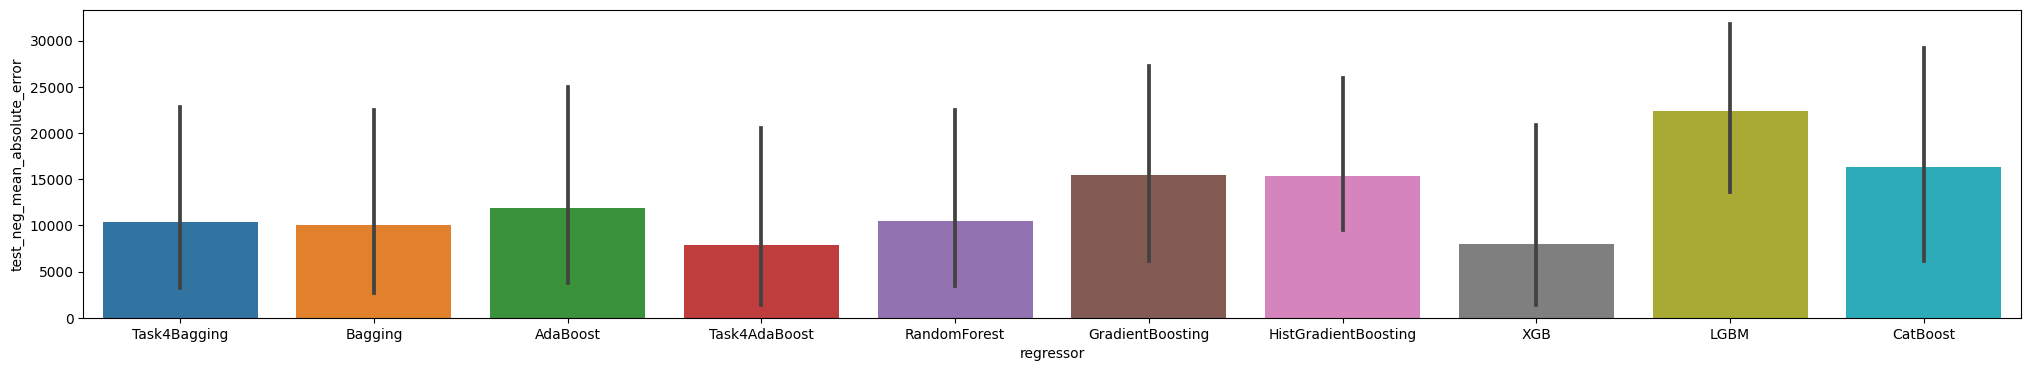

In [41]:
plt.figure(figsize=(25,4))
sns.barplot(x='regressor', y='test_neg_mean_absolute_error', data=results)

<Axes: xlabel='regressor', ylabel='test_neg_mean_absolute_error'>

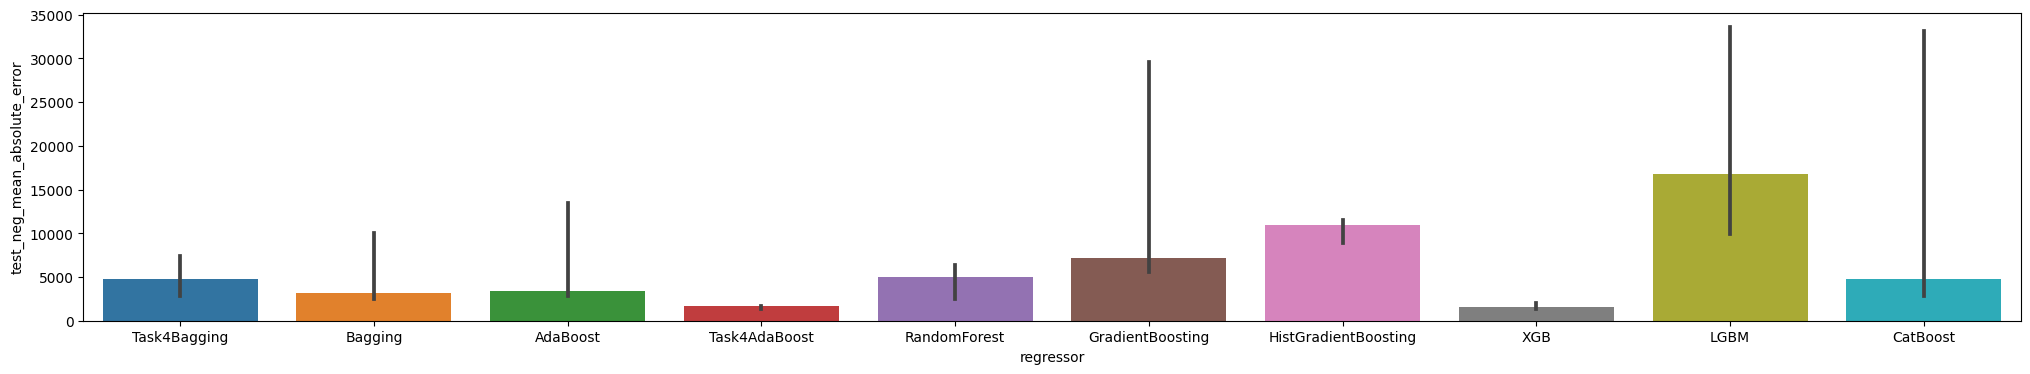

In [42]:
plt.figure(figsize=(25,4))
sns.barplot(x='regressor', y='test_neg_mean_absolute_error', data=results, estimator="median")

Несмотря на то, что в среднем все модели показывают огромною ошибку (порядка 10-20 миллионов, что абсолютно неприемлимо для оценки), для части разбиений регрессоры Task4AdaBoostRegressor и XGBRegressor показывают хорошую предсказательную способность. Вероятно такой результат связан с качеством данных, которые были выбраны (первые 100_000 записей о продаже жилья из 1_000_000), и если выбрать большую по размеру выборку показатели угадывания станут лучше.

In [44]:
pd.set_option('display.max_rows', 500)
display(results)

,fit_time,score_time,regressor,test_r2,train_r2,test_neg_mean_absolute_error,train_neg_mean_absolute_error
0,1250.814459,0.397825,Task4Bagging,-187.238308,0.889426,2781.850575,4714.190352
1,1474.764574,0.232768,Task4Bagging,-127.755862,0.801871,4761.051254,6645.747656
2,1673.902117,0.229730,Task4Bagging,-155.119725,0.790620,2178.574712,4794.030601
3,1758.161132,0.468650,Task4Bagging,-162.434496,0.761564,3082.189093,4618.905916
4,1813.898489,0.453678,Task4Bagging,-2193.204355,0.815626,7442.149126,5710.713518
5,1388.348838,0.357498,Task4Bagging,-149.874663,0.869160,5657.267021,4576.136041
6,1119.296446,0.394166,Task4Bagging,-0.000077,0.756114,46267.068408,439.337450
0,1313.113161,0.237795,Bagging,-2255.885679,0.971838,10043.532802,3342.873220
1,1055.364514,0.282649,Bagging,-157.188567,0.920599,2538.927701,3686.554692
2,1278.875919,0.283984,Bagging,-0.000075,0.786445,45563.545391,526.989283


# Вывод

Судя по качеству предсказаний моделей, набора из 100_000 тысяч записей о продаже жилья недостаточно для обучения моделей, способных предсказывать стоимость произвольного жилья по его геолокации, региону, этажу и площади точнее, чем константный предсказатель. Возможно, увеличение количества записей в выборке повысит ее репрезентативность и качество моделей станет лучше.

Также вероятно, что сами данные имеют плохое качество, ведь были собраны с сайтов объявлений для продажи жилья и отражают лишь стоимость, которую хозяин хочет получить. Возможно, конечная цена будет отличаться в зависимости от того, как хозяин договориться с покупателем, и цена, указанная на сайте, окажется слишком завышенной.

Тем не менее, лучший результат из всех получилось добиться от XGBRegressor, который для части из разбиений, получившихся при кросс валидации, смог добиться средней ошибки в 1,5 миллиона рублей, что сравнительно является довольно точным предсказанием.